# Projeto Grupo BT-G3


## **Integrantes do grupo**
- Daniel Barzilai
- Larissa Carvalho
- Maria Luisa Maia
- Pedro Rezende
- Rafael Moritz
- Vitor Oliveira

<center><img src="https://www.inteli.edu.br/wp-content/uploads/2021/08/20172028/marca_1-2.png" width="50%" height="50%"/></center>

<h1 align='center'><b>IA para Marketing: Monitoramento de campanhas utilizando processamento de linguagem natural (PLN)<b></h1>

<center><img src="https://upload.wikimedia.org/wikipedia/commons/c/c2/Btg-logo-blue.svg" width="50%" height="50%"/></center>

<h2 align='center'>O Banco BTG Pactual enfrenta um desafio na área de Marketing em entender as necessidades e demandas dos clientes de maneira fácil e rápida nas redes sociais. A solução proposta para esse problema foi o desenvolvimento de uma Inteligência Artificial utilizando processamento de linguagem natural (PLN), capaz de monitorar as campanhas de marketing, voltadas para o Instagram. O objetivo principal dessa solução é rastrear os dados em tempo real, analisar e interpretar as mensagens e comentários enviados pelos clientes na rede social, a fim de identificar as necessidades e demandas de forma precisa e eficiente.</h2>

---

# Sobre os dados

Esse projeto está utilizando dados coletados e tratados pela equipe de Automation do BTG Pactual, o qual disponibilizou o dataset. Com base nas informações dispostas nesse dataset, realizaremos insights a cerca dos comentários feitos nos posts do Instagram do próprio banco. Vale lembrar que os dados estão anonimizados e resguardados para manter a privacidade e ética com os usuários e com o banco.

# 1. Instalação / Setup

Para o início do projeto, fizemos o desenvolvimento no Google Colab, por isso temos uma célula de conexão com o Google Drive, para poder acessar os dados. Caso seja rodado no Jupyter Notebook, precisará do dataset baixado.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Aqui nós fazemos as importações para tratamento dos dados, pré-processamento dos dados e modelamento do Bag of Words. 

## pips

In [2]:
!pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 64.0 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.2
    Uninstalling spacy-3.5.2:
      Successfully uninstalled spacy-3.5.2


In [3]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

from sklearn.feature_extraction.text import CountVectorizer
import ast
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import nltk
import spacy
import gensim
from scipy.spatial.distance import cosine
from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

import pickle

# 2. Entendimento e Tratamento dos Dados

Rodando o dataset, para analisar seu conteúdo:

In [8]:
df = pd.read_csv('/content/drive/MyDrive/Projeto_Modulo6/nova_base_tratada2')
df

,autor,sentimento,texto_tratado
0,winthegame_of,1,"['alvarez', 'marsal', 'estar', 'conosco', 'spo..."
1,marta_bego,1,"['btgpactual', 'with', 'make_repost', 'entenda..."
2,lmviapiana,2,"['minuto', 'touro', 'ouro']"
3,ricktolledo,2,"['querer', 'saber', 'banking', 'administrar']"
4,donadabolsaoficial,0,"['início', 'guerra', 'rússia', 'ucrânia', 'vel..."
...,...,...,...
8035,perspectiveinvestimentos,2,"['excelente', 'explicação']"
8036,eduardocolares,2,"['atendar', 'telefone', 'amor', 'deus']"
8037,danielucm,2,"['grande', 'fiis', 'mercado', 'não', 'selecion..."
8038,amgcapitalinvest,1,"['erro', 'financeiro', 'eliminar', 'parar', 'o..."


In [9]:
df.columns

Index(['autor', 'sentimento', 'texto_tratado'], dtype='object')

In [12]:
df['texto_tratado']

0       ['alvarez', 'marsal', 'estar', 'conosco', 'spo...
1       ['btgpactual', 'with', 'make_repost', 'entenda...
2                             ['minuto', 'touro', 'ouro']
3           ['querer', 'saber', 'banking', 'administrar']
4       ['início', 'guerra', 'rússia', 'ucrânia', 'vel...
                              ...                        
8035                          ['excelente', 'explicação']
8036              ['atendar', 'telefone', 'amor', 'deus']
8037    ['grande', 'fiis', 'mercado', 'não', 'selecion...
8038    ['erro', 'financeiro', 'eliminar', 'parar', 'o...
8039    ['morning', 'call', 'não', 'aparecer', 'spotif...
Name: texto_tratado, Length: 8040, dtype: object

In [13]:
# Supondo que seu DataFrame seja chamado de df e a coluna seja 'texto_tratado'
df['texto_tratado'] = df['texto_tratado'].str.replace("'", "")
df['texto_tratado']

0       [alvarez, marsal, estar, conosco, sportainmet,...
1       [btgpactual, with, make_repost, entendar, impa...
2                                   [minuto, touro, ouro]
3                   [querer, saber, banking, administrar]
4       [início, guerra, rússia, ucrânia, velho, apare...
                              ...                        
8035                              [excelente, explicação]
8036                      [atendar, telefone, amor, deus]
8037    [grande, fiis, mercado, não, selecionar, princ...
8038    [erro, financeiro, eliminar, parar, ostentar, ...
8039    [morning, call, não, aparecer, spotify, atuali...
Name: texto_tratado, Length: 8040, dtype: object

# 3. Bag of Words (BoW) - **CORRIGIR**

O modelo Bag of Words (BoW) é uma técnica utilizada em processamento de linguagem natural para representar um texto como um conjunto de palavras desordenadas, ignorando a ordem e a estrutura gramatical das frases. 

Nesse modelo, cada palavra única do texto é transformada em uma "feature" (característica), e a frequência de cada palavra no texto é usada como um valor numérico para a feature correspondente.

Por exemplo, a frase "O gato preto pulou o muro" seria representada como um conjunto de palavras desordenadas: `'o', 'gato', 'preto', 'pulou', 'o', 'muro'`. A frequência de cada palavra seria contada, e o resultado seria um vetor numérico que representa a frequência de cada palavra na frase.


## 3.1 Teste isolado

In [14]:
# Multiple documents
text = ["Estamos fazendo um projeto pro BTG!", "Somos alunos de Sistemas de Informação do Inteli", "O Renato é o nosso orientador", "O Hayashi é o nosso professor de programação"] 

# create the transform
vectorizer = CountVectorizer()

# tokenize and build vocab
vectorizer.fit(text)

# summarize
print(sorted(vectorizer.vocabulary_))

# encode document
vector = vectorizer.transform(text)

# summarize encoded vector
print(vector.shape)
print(vector.toarray())

['alunos', 'btg', 'de', 'do', 'estamos', 'fazendo', 'hayashi', 'informação', 'inteli', 'nosso', 'orientador', 'pro', 'professor', 'programação', 'projeto', 'renato', 'sistemas', 'somos', 'um']
(4, 19)
[[0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1]
 [1 0 2 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0]]


**AVISO**:
O modelo Bag of Words é uma técnica simples e eficiente para representar textos em formato vetorial, o que permite utilizá-los em algoritmos de aprendizado de máquina. 

No entanto, essa abordagem ignora informações importantes sobre a estrutura e o significado das frases, como a ordem das palavras e as relações sintáticas entre elas. Por isso, é comum utilizar técnicas mais avançadas, como a modelagem de tópicos (topic modeling) e as redes neurais, para lidar com textos mais complexos.

Porém, para vieses acadêmicos, estamos implementando e aprendendo como é o funcionamento desse processo.

## 3.2 Definição da Função


In [15]:
df

,autor,sentimento,texto_tratado
0,winthegame_of,1,"[alvarez, marsal, estar, conosco, sportainmet,..."
1,marta_bego,1,"[btgpactual, with, make_repost, entendar, impa..."
2,lmviapiana,2,"[minuto, touro, ouro]"
3,ricktolledo,2,"[querer, saber, banking, administrar]"
4,donadabolsaoficial,0,"[início, guerra, rússia, ucrânia, velho, apare..."
...,...,...,...
8035,perspectiveinvestimentos,2,"[excelente, explicação]"
8036,eduardocolares,2,"[atendar, telefone, amor, deus]"
8037,danielucm,2,"[grande, fiis, mercado, não, selecionar, princ..."
8038,amgcapitalinvest,1,"[erro, financeiro, eliminar, parar, ostentar, ..."


In [16]:
df['texto_tratado']

0       [alvarez, marsal, estar, conosco, sportainmet,...
1       [btgpactual, with, make_repost, entendar, impa...
2                                   [minuto, touro, ouro]
3                   [querer, saber, banking, administrar]
4       [início, guerra, rússia, ucrânia, velho, apare...
                              ...                        
8035                              [excelente, explicação]
8036                      [atendar, telefone, amor, deus]
8037    [grande, fiis, mercado, não, selecionar, princ...
8038    [erro, financeiro, eliminar, parar, ostentar, ...
8039    [morning, call, não, aparecer, spotify, atuali...
Name: texto_tratado, Length: 8040, dtype: object

In [17]:
def bow(frases):
    # Inicializa o CountVectorizer
    vectorizer = CountVectorizer()

    # Concatena os tokens de cada frase em uma única string
    frases_concatenadas = [''.join(tokens) for tokens in frases]

    # Cria o modelo Bag of Words
    bow_model = vectorizer.fit_transform(frases_concatenadas)

    # Dicionário de palavras
    dicionario = vectorizer.vocabulary_

    bow_df = pd.DataFrame(bow_model.toarray(), columns=vectorizer.get_feature_names_out())

    return bow_model, dicionario, bow_df

# Aplicar a função de Bag of Words
bow_model, dicionario, bow_df = bow(df['texto_tratado'].tolist())

In [18]:
# Imprime o vocabulário de palavras
print("Dicionário de palavras:")
print(dicionario, "\n")

# Imprime a matriz Bag of Words
print("Representação Bag of Words:")
print(bow_model.toarray())

Dicionário de palavras:
{'alvarez': 735, 'marsal': 10926, 'estar': 6432, 'conosco': 3932, 'sportainmet': 16172, 'labsr': 9961, 'evento': 6593, 'sportainment': 16171, 'américar': 863, 'latino': 10040, 'parceria': 12709, 'hubstage': 8552, 'bichar': 2086, 'motta': 11599, 'advogado': 368, 'win': 18071, 'the': 16750, 'game': 7726, 'participe': 12747, 'online': 12367, 'gratuito': 8108, 'março': 10946, 'inscreva': 9110, 'link': 10302, 'bio': 2110, 'btgpactual': 2490, 'with': 18086, 'make_repost': 10701, 'entendar': 6104, 'impacto': 8765, 'conflito': 3884, 'rússia': 15320, 'ucrânio': 17275, 'cenário': 3097, 'global': 7949, 'live': 10334, 'inédito': 9383, 'amanhã': 767, 'anatole': 894, 'kaletsky': 9837, 'sócio': 16470, 'fundador': 7607, 'economista': 5686, 'chefe': 3221, 'gavekal': 7786, 'research': 14845, 'joão': 9729, 'scandiuzzi': 15526, 'estrategista': 6487, 'wealth': 18011, 'management': 10727, 'moderação': 11462, 'daniel': 4624, 'cunha': 4499, 'vivo': 17878, 'canal': 2720, 'youtube': 1817

---

In [19]:
bow_df

,a_aphotographs,a_doce_casa,aa,aaa,aaaah,aaaahhh,aabb,aabbrio,aacdoficial,aai,...,𝚜𝚎𝚛,𝚜𝚎𝚞𝚜,𝚜𝚞𝚊,𝚝𝚎,𝚝𝚞𝚍𝚘,𝚞𝚖𝚊,𝚟𝚊,𝚟𝚊𝚒,𝚟𝚊𝚕𝚘𝚛𝚎𝚜,𝚟𝚘𝚕𝚊𝚝𝚒𝚕𝚒𝚍𝚊𝚍𝚎
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# # Criando a função de vetorização, a qual irá criar um DataFrame com todos os termos e suas contabilizações em cada comentário (representados pelo index)
# def bow(comentarios): 
#      # Inicializa o CountVectorizer
#     vectorizer = CountVectorizer(analyzer=lambda x: x)
#     # Cria o modelo Bag of Words
#     bow_model = vectorizer.fit_transform(comentarios)
#     # Dicionário de palavras
#     dicionario = vectorizer.vocabulary_
#     # Cria um dataframe com as palavras e suas frequências
#     bow_df = pd.DataFrame(bow_model.toarray(), columns=vectorizer.get_feature_names_out())
#     return bow_df, dicionario

# bow_model, dicionario = bow(df['texto_tratado'])

In [21]:
# bow_model, dicionario

In [22]:
# # Imprime o vocabulário de palavras
# print("Dicionário de palavras:")
# print(dicionario, "\n")

---

# 10. Word2Vec com CBOW

## Estruturação

Nesse caso, o grupo utilizou um modelo já pré treinado, que está sendo referenciado abaixo.

In [23]:
df

,autor,sentimento,texto_tratado
0,winthegame_of,1,"[alvarez, marsal, estar, conosco, sportainmet,..."
1,marta_bego,1,"[btgpactual, with, make_repost, entendar, impa..."
2,lmviapiana,2,"[minuto, touro, ouro]"
3,ricktolledo,2,"[querer, saber, banking, administrar]"
4,donadabolsaoficial,0,"[início, guerra, rússia, ucrânia, velho, apare..."
...,...,...,...
8035,perspectiveinvestimentos,2,"[excelente, explicação]"
8036,eduardocolares,2,"[atendar, telefone, amor, deus]"
8037,danielucm,2,"[grande, fiis, mercado, não, selecionar, princ..."
8038,amgcapitalinvest,1,"[erro, financeiro, eliminar, parar, ostentar, ..."


In [24]:
cbow = '/content/drive/MyDrive/Projeto_Modulo6/cbow_s50.txt'

In [25]:
model_cbow = KeyedVectors.load_word2vec_format(cbow)

## Teste isolado

Para testar se o modelo está funcionando, testamos com a palavra 'projeto'.

In [26]:
# Testando o word2vec
wordvec_test = model_cbow['projeto']

wordvec_test

array([-0.074174, -0.152088,  0.086627, -0.224567,  0.362562,  0.130683,
       -0.089179, -0.086973,  0.309501,  0.004112, -0.308202,  0.351789,
       -0.477863,  0.050276,  0.213283,  0.159895, -0.285545, -0.08832 ,
       -0.015449,  0.014816, -0.613861,  0.502556,  0.021688,  0.369492,
        0.280691,  0.016868,  0.105584, -0.180754, -0.078456,  0.148032,
        0.36293 , -0.011634,  0.412191, -0.009049,  0.010404,  0.131242,
       -0.032483, -0.133067, -0.063802,  0.434015, -0.214768, -0.072132,
        0.045601, -0.368866,  0.502808,  0.048293, -0.254894,  0.142581,
       -0.075066,  0.015646], dtype=float32)

## Definição de função

A função abaixo define uma função chamada "create_sentence_vector" que tem como objetivo criar um vetor de representação para cada sentença do DataFrame fornecido. 

In [27]:
def create_sentence_vector(model, df):
    sentence_table = []
    for sentence in df['texto_tratado']:
        word_vectors = [model[word] for word in sentence if word in model]
        if len(word_vectors) > 0:
            sentence_vector = sum(word_vectors) / len(word_vectors)
        else:
            sentence_vector = [None] * 100  # Cria uma lista de 100 elementos None
        sentence_table.append((sentence, *sentence_vector[:50]))  # Adiciona apenas os primeiros 50 elementos do vetor

    column_labels = ['Frase']
    for i in range(50):
        column_labels.append(f'Vetor{i+1}')
    df_vec = pd.DataFrame(sentence_table, columns=column_labels)

    df["sentimentoNumerico"] = df["sentimento"].replace({'NEGATIVE': -1, 'POSITIVE': 1, 'NEUTRAL': 0})

    # Definir o índice do DataFrame df_vec como o mesmo índice de df_processada['sentimentoNumerico']
    df_vec.set_index(df["sentimentoNumerico"].index, inplace=True)

    df_vec['sentimento'] = df["sentimentoNumerico"]
    df_vec = df_vec.dropna()

    return df_vec

## Teste de funções

Abaixo, a função definida acima é testada no dataframe inteiro, que cria 50 colunas (vetores) e a última coluna é o sentimento gerado naquela frase, que já está tratado.

In [28]:
df_vec = create_sentence_vector(model_cbow, df)
df_vec

,Frase,Vetor1,Vetor2,Vetor3,Vetor4,Vetor5,Vetor6,Vetor7,Vetor8,Vetor9,...,Vetor42,Vetor43,Vetor44,Vetor45,Vetor46,Vetor47,Vetor48,Vetor49,Vetor50,sentimento
0,"[alvarez, marsal, estar, conosco, sportainmet,...",0.214823,-0.123036,0.220707,-0.079739,-0.019442,0.202300,0.073742,0.042477,0.057268,...,0.012086,-0.096122,0.148153,0.092629,-0.027504,0.149860,-0.029617,0.032065,0.190372,1
1,"[btgpactual, with, make_repost, entendar, impa...",0.220860,-0.123713,0.205813,-0.063700,-0.010433,0.195687,0.072226,0.026175,0.058045,...,0.006447,-0.076174,0.157446,0.085306,-0.001963,0.156306,-0.019182,0.035594,0.192635,1
2,"[minuto, touro, ouro]",0.265227,-0.068285,0.152235,-0.044329,-0.102729,0.141353,0.092800,0.113174,0.015783,...,0.078032,-0.202677,0.155750,0.062291,0.007038,0.134573,0.014635,0.034189,0.345674,2
3,"[querer, saber, banking, administrar]",0.189241,-0.169407,0.281181,-0.093912,-0.001968,0.181633,0.080923,0.055674,0.103454,...,0.092738,-0.160601,0.179499,0.091803,-0.063762,0.171190,-0.043618,0.030563,0.196250,2
4,"[início, guerra, rússia, ucrânia, velho, apare...",0.219838,-0.138311,0.229412,-0.057420,-0.014510,0.212875,0.058865,0.068096,0.060398,...,0.040836,-0.112662,0.170401,0.094290,-0.046000,0.168181,-0.018029,0.027667,0.180134,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,"[excelente, explicação]",0.190917,-0.133475,0.241675,-0.053180,0.067256,0.201138,0.034109,-0.078718,-0.066131,...,-0.082151,0.016113,0.154861,0.068700,-0.004302,0.079717,-0.028388,-0.017448,0.188785,2
8036,"[atendar, telefone, amor, deus]",0.188641,-0.119377,0.199339,-0.105448,0.023176,0.178837,0.069476,-0.004494,0.034710,...,0.034035,-0.126673,0.165176,0.080313,-0.024160,0.118848,-0.003502,0.087053,0.215656,2
8037,"[grande, fiis, mercado, não, selecionar, princ...",0.219437,-0.141124,0.217854,-0.065569,-0.020409,0.205403,0.061334,0.041665,0.063050,...,0.031438,-0.099000,0.176588,0.092546,-0.046104,0.145734,-0.019857,0.029422,0.183504,2
8038,"[erro, financeiro, eliminar, parar, ostentar, ...",0.218153,-0.146420,0.245234,-0.056113,-0.036187,0.224789,0.074320,0.045111,0.040841,...,0.035260,-0.126793,0.171115,0.095479,-0.033473,0.158747,-0.006721,0.029326,0.198914,1


In [29]:
#df_vec.to_csv('Word2Vec_Cbow_modelo_treinado',encoding='utf-8', index=False, header=True)

# 11. Naive Bayes + Word2Vec com CBOW

O Naive Bayes é um algoritmo utilizado para classificação de textos com base em representações vetoriais. O Word2Vec com CBoW é um algoritmo de aprendizado de representações vetoriais. 

Nesse tópico vamos juntar os dois para classificar os textos.

In [30]:
label = preprocessing.LabelEncoder()

In [31]:
label.fit(df_vec['sentimento'])
df_vec['sentimento'] = label.transform(df_vec['sentimento'])

In [32]:
df_vec = df_vec.dropna()
df_vec

,Frase,Vetor1,Vetor2,Vetor3,Vetor4,Vetor5,Vetor6,Vetor7,Vetor8,Vetor9,...,Vetor42,Vetor43,Vetor44,Vetor45,Vetor46,Vetor47,Vetor48,Vetor49,Vetor50,sentimento
0,"[alvarez, marsal, estar, conosco, sportainmet,...",0.214823,-0.123036,0.220707,-0.079739,-0.019442,0.202300,0.073742,0.042477,0.057268,...,0.012086,-0.096122,0.148153,0.092629,-0.027504,0.149860,-0.029617,0.032065,0.190372,1
1,"[btgpactual, with, make_repost, entendar, impa...",0.220860,-0.123713,0.205813,-0.063700,-0.010433,0.195687,0.072226,0.026175,0.058045,...,0.006447,-0.076174,0.157446,0.085306,-0.001963,0.156306,-0.019182,0.035594,0.192635,1
2,"[minuto, touro, ouro]",0.265227,-0.068285,0.152235,-0.044329,-0.102729,0.141353,0.092800,0.113174,0.015783,...,0.078032,-0.202677,0.155750,0.062291,0.007038,0.134573,0.014635,0.034189,0.345674,2
3,"[querer, saber, banking, administrar]",0.189241,-0.169407,0.281181,-0.093912,-0.001968,0.181633,0.080923,0.055674,0.103454,...,0.092738,-0.160601,0.179499,0.091803,-0.063762,0.171190,-0.043618,0.030563,0.196250,2
4,"[início, guerra, rússia, ucrânia, velho, apare...",0.219838,-0.138311,0.229412,-0.057420,-0.014510,0.212875,0.058865,0.068096,0.060398,...,0.040836,-0.112662,0.170401,0.094290,-0.046000,0.168181,-0.018029,0.027667,0.180134,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,"[excelente, explicação]",0.190917,-0.133475,0.241675,-0.053180,0.067256,0.201138,0.034109,-0.078718,-0.066131,...,-0.082151,0.016113,0.154861,0.068700,-0.004302,0.079717,-0.028388,-0.017448,0.188785,2
8036,"[atendar, telefone, amor, deus]",0.188641,-0.119377,0.199339,-0.105448,0.023176,0.178837,0.069476,-0.004494,0.034710,...,0.034035,-0.126673,0.165176,0.080313,-0.024160,0.118848,-0.003502,0.087053,0.215656,2
8037,"[grande, fiis, mercado, não, selecionar, princ...",0.219437,-0.141124,0.217854,-0.065569,-0.020409,0.205403,0.061334,0.041665,0.063050,...,0.031438,-0.099000,0.176588,0.092546,-0.046104,0.145734,-0.019857,0.029422,0.183504,2
8038,"[erro, financeiro, eliminar, parar, ostentar, ...",0.218153,-0.146420,0.245234,-0.056113,-0.036187,0.224789,0.074320,0.045111,0.040841,...,0.035260,-0.126793,0.171115,0.095479,-0.033473,0.158747,-0.006721,0.029326,0.198914,1


## Separando Treino e Teste

É necessário separar quais são as frases de teste e de treino, processo realizado abaixo.

In [33]:
target = df_vec['sentimento']

In [34]:
feature = df_vec.iloc[:,1:50]

In [35]:
feature

,Vetor1,Vetor2,Vetor3,Vetor4,Vetor5,Vetor6,Vetor7,Vetor8,Vetor9,Vetor10,...,Vetor40,Vetor41,Vetor42,Vetor43,Vetor44,Vetor45,Vetor46,Vetor47,Vetor48,Vetor49
0,0.214823,-0.123036,0.220707,-0.079739,-0.019442,0.202300,0.073742,0.042477,0.057268,0.168187,...,0.076954,-0.281536,0.012086,-0.096122,0.148153,0.092629,-0.027504,0.149860,-0.029617,0.032065
1,0.220860,-0.123713,0.205813,-0.063700,-0.010433,0.195687,0.072226,0.026175,0.058045,0.163238,...,0.086821,-0.305640,0.006447,-0.076174,0.157446,0.085306,-0.001963,0.156306,-0.019182,0.035594
2,0.265227,-0.068285,0.152235,-0.044329,-0.102729,0.141353,0.092800,0.113174,0.015783,0.202198,...,-0.008447,-0.193025,0.078032,-0.202677,0.155750,0.062291,0.007038,0.134573,0.014635,0.034189
3,0.189241,-0.169407,0.281181,-0.093912,-0.001968,0.181633,0.080923,0.055674,0.103454,0.144342,...,0.060960,-0.254610,0.092738,-0.160601,0.179499,0.091803,-0.063762,0.171190,-0.043618,0.030563
4,0.219838,-0.138311,0.229412,-0.057420,-0.014510,0.212875,0.058865,0.068096,0.060398,0.156307,...,0.067551,-0.269136,0.040836,-0.112662,0.170401,0.094290,-0.046000,0.168181,-0.018029,0.027667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,0.190917,-0.133475,0.241675,-0.053180,0.067256,0.201138,0.034109,-0.078718,-0.066131,0.187608,...,0.014565,-0.321192,-0.082151,0.016113,0.154861,0.068700,-0.004302,0.079717,-0.028388,-0.017448
8036,0.188641,-0.119377,0.199339,-0.105448,0.023176,0.178837,0.069476,-0.004494,0.034710,0.150081,...,0.071114,-0.194663,0.034035,-0.126673,0.165176,0.080313,-0.024160,0.118848,-0.003502,0.087053
8037,0.219437,-0.141124,0.217854,-0.065569,-0.020409,0.205403,0.061334,0.041665,0.063050,0.167985,...,0.077558,-0.300234,0.031438,-0.099000,0.176588,0.092546,-0.046104,0.145734,-0.019857,0.029422
8038,0.218153,-0.146420,0.245234,-0.056113,-0.036187,0.224789,0.074320,0.045111,0.040841,0.150971,...,0.060317,-0.270532,0.035260,-0.126793,0.171115,0.095479,-0.033473,0.158747,-0.006721,0.029326


In [36]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)

## Avaliação do modelo 

Abaixo é calculado a acurácia, média macro e média ponderada do modelo.

In [ ]:
clf = GaussianNB()

clf = clf.fit(X_train,y_train.values.ravel())

Y_pred = clf.predict(X_test)

print(classification_report(y_test, Y_pred))

In [38]:
acc_score = accuracy_score(y_test, Y_pred)
format_output = "{:.2%}".format(acc_score)
print("Precisão final de :",format_output) 

Precisão final de : 31.47%


# 12. Word2Vec com embedding layer

## Definição de função

A função abaixo utiliza a biblioteca Gensim para treinar o Word2Vec, que recebe a coluna do dataframe.

In [39]:
from gensim.models import Word2Vec

# Função que treina o modelo Word2Vec no corpus do dataframe
def train_word2vec(df, column_name):
    # Obtém as frases tokenizadas
    sentences = df[column_name].tolist()
    
    # Treina o modelo Word2Vec
    model = Word2Vec(sentences, min_count=1)
    
    return model

A primeira função recebe o Word2Vec já treinado e itera as palavras (input) da lista para verificar se está presente no modelo.

A segunda função cria um novo dataframe com o modelo Word2Vec.

In [40]:
# Função que define os vetores para cada palavra do vocabulario
def get_word_vectors(model, sentence):
    vectors = []
    for word in sentence:
        if word in model.wv:
            vectors.append(model.wv[word]) # Append na lista de vetores
    if vectors:
        return np.sum(vectors, axis=0)/len(sentence) # Soma dos vetores para cada frase
    else:
        return np.zeros(model.vector_size)

# Criação do dataframe de vetores para cada frase
def create_word2vec_dataframe(df, column_name, model):
    sentences = df[column_name].tolist()
    vectors = [get_word_vectors(model, sentence) for sentence in sentences] # Itera para cada frase um vetor
    # Criação do dataframe
    df_vectors = pd.DataFrame(vectors, columns=[f"Vetor{i}" for i in range(model.vector_size)])
    df_word2vec = pd.concat([df, df_vectors], axis=1)
    return df_word2vec

## Teste de funções

Abaixo são testados as funções que foram criadas acima.

In [41]:
model = train_word2vec(df, 'texto_tratado')

In [42]:
df_word2vec = create_word2vec_dataframe(df,'texto_tratado', model)
df_word2vec

,autor,sentimento,texto_tratado,sentimentoNumerico,Vetor0,Vetor1,Vetor2,Vetor3,Vetor4,Vetor5,...,Vetor90,Vetor91,Vetor92,Vetor93,Vetor94,Vetor95,Vetor96,Vetor97,Vetor98,Vetor99
0,winthegame_of,1,"[alvarez, marsal, estar, conosco, sportainmet,...",1,-0.040596,0.201057,-0.587482,-0.461829,0.090562,0.185413,...,-0.070598,0.085019,0.106268,0.070255,0.072888,0.196763,-0.110067,-0.283604,0.448293,-0.081263
1,marta_bego,1,"[btgpactual, with, make_repost, entendar, impa...",1,-0.052535,0.204952,-0.554421,-0.419977,0.079677,0.176239,...,-0.054085,0.078274,0.099261,0.043703,0.062975,0.207802,-0.127206,-0.247713,0.414140,-0.060320
2,lmviapiana,2,"[minuto, touro, ouro]",2,-0.137447,0.166970,-0.615913,-0.427152,-0.087120,0.212885,...,-0.153962,0.138240,-0.055025,0.041938,0.037115,0.260403,0.014757,-0.360261,0.534301,-0.110851
3,ricktolledo,2,"[querer, saber, banking, administrar]",2,-0.043030,0.167756,-0.533593,-0.422472,0.144987,0.115414,...,-0.065003,0.020102,0.159093,-0.015751,0.092890,0.278625,-0.030780,-0.301135,0.446972,-0.077218
4,donadabolsaoficial,0,"[início, guerra, rússia, ucrânia, velho, apare...",0,-0.075185,0.243127,-0.590974,-0.436435,0.058026,0.187044,...,-0.045425,0.066263,0.105139,0.042431,0.047273,0.185428,-0.138649,-0.274532,0.446329,-0.051511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,perspectiveinvestimentos,2,"[excelente, explicação]",2,-0.146040,0.258804,-0.466082,-0.452530,0.070121,0.137384,...,0.149279,0.030351,0.110613,-0.017123,-0.041833,0.151780,-0.060871,-0.231545,0.386411,-0.070098
8036,eduardocolares,2,"[atendar, telefone, amor, deus]",2,-0.094132,0.271853,-0.608205,-0.468443,0.084511,0.179713,...,-0.006844,0.078776,0.108811,-0.019303,-0.003754,0.211196,-0.134939,-0.281820,0.467868,-0.083125
8037,danielucm,2,"[grande, fiis, mercado, não, selecionar, princ...",2,-0.058298,0.248697,-0.580123,-0.434655,0.027439,0.206130,...,-0.024670,0.073256,0.073779,0.058785,0.009258,0.158732,-0.173623,-0.252529,0.434525,-0.018273
8038,amgcapitalinvest,1,"[erro, financeiro, eliminar, parar, ostentar, ...",1,-0.074940,0.267129,-0.619967,-0.453707,0.054354,0.226676,...,-0.052946,0.078625,0.086394,0.056885,0.030777,0.179850,-0.137322,-0.255487,0.465313,-0.038463


In [43]:
df_word2vec = df_word2vec.drop(columns=['autor', 'sentimento'])
df_word2vec

,texto_tratado,sentimentoNumerico,Vetor0,Vetor1,Vetor2,Vetor3,Vetor4,Vetor5,Vetor6,Vetor7,...,Vetor90,Vetor91,Vetor92,Vetor93,Vetor94,Vetor95,Vetor96,Vetor97,Vetor98,Vetor99
0,"[alvarez, marsal, estar, conosco, sportainmet,...",1,-0.040596,0.201057,-0.587482,-0.461829,0.090562,0.185413,-0.285650,-0.056377,...,-0.070598,0.085019,0.106268,0.070255,0.072888,0.196763,-0.110067,-0.283604,0.448293,-0.081263
1,"[btgpactual, with, make_repost, entendar, impa...",1,-0.052535,0.204952,-0.554421,-0.419977,0.079677,0.176239,-0.288785,-0.054338,...,-0.054085,0.078274,0.099261,0.043703,0.062975,0.207802,-0.127206,-0.247713,0.414140,-0.060320
2,"[minuto, touro, ouro]",2,-0.137447,0.166970,-0.615913,-0.427152,-0.087120,0.212885,-0.254145,-0.028276,...,-0.153962,0.138240,-0.055025,0.041938,0.037115,0.260403,0.014757,-0.360261,0.534301,-0.110851
3,"[querer, saber, banking, administrar]",2,-0.043030,0.167756,-0.533593,-0.422472,0.144987,0.115414,-0.262763,0.005590,...,-0.065003,0.020102,0.159093,-0.015751,0.092890,0.278625,-0.030780,-0.301135,0.446972,-0.077218
4,"[início, guerra, rússia, ucrânia, velho, apare...",0,-0.075185,0.243127,-0.590974,-0.436435,0.058026,0.187044,-0.280026,-0.081321,...,-0.045425,0.066263,0.105139,0.042431,0.047273,0.185428,-0.138649,-0.274532,0.446329,-0.051511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,"[excelente, explicação]",2,-0.146040,0.258804,-0.466082,-0.452530,0.070121,0.137384,-0.210961,-0.164016,...,0.149279,0.030351,0.110613,-0.017123,-0.041833,0.151780,-0.060871,-0.231545,0.386411,-0.070098
8036,"[atendar, telefone, amor, deus]",2,-0.094132,0.271853,-0.608205,-0.468443,0.084511,0.179713,-0.285182,-0.073410,...,-0.006844,0.078776,0.108811,-0.019303,-0.003754,0.211196,-0.134939,-0.281820,0.467868,-0.083125
8037,"[grande, fiis, mercado, não, selecionar, princ...",2,-0.058298,0.248697,-0.580123,-0.434655,0.027439,0.206130,-0.289194,-0.108199,...,-0.024670,0.073256,0.073779,0.058785,0.009258,0.158732,-0.173623,-0.252529,0.434525,-0.018273
8038,"[erro, financeiro, eliminar, parar, ostentar, ...",1,-0.074940,0.267129,-0.619967,-0.453707,0.054354,0.226676,-0.277436,-0.100812,...,-0.052946,0.078625,0.086394,0.056885,0.030777,0.179850,-0.137322,-0.255487,0.465313,-0.038463


# 13. Naive Bayes + Word2Vec com embedding layer

Essa abordagem é utilizada para realizar classificação de texto com base no Word2Vec.

In [44]:
df_word2vec = df_word2vec.dropna()
df_word2vec

,texto_tratado,sentimentoNumerico,Vetor0,Vetor1,Vetor2,Vetor3,Vetor4,Vetor5,Vetor6,Vetor7,...,Vetor90,Vetor91,Vetor92,Vetor93,Vetor94,Vetor95,Vetor96,Vetor97,Vetor98,Vetor99
0,"[alvarez, marsal, estar, conosco, sportainmet,...",1,-0.040596,0.201057,-0.587482,-0.461829,0.090562,0.185413,-0.285650,-0.056377,...,-0.070598,0.085019,0.106268,0.070255,0.072888,0.196763,-0.110067,-0.283604,0.448293,-0.081263
1,"[btgpactual, with, make_repost, entendar, impa...",1,-0.052535,0.204952,-0.554421,-0.419977,0.079677,0.176239,-0.288785,-0.054338,...,-0.054085,0.078274,0.099261,0.043703,0.062975,0.207802,-0.127206,-0.247713,0.414140,-0.060320
2,"[minuto, touro, ouro]",2,-0.137447,0.166970,-0.615913,-0.427152,-0.087120,0.212885,-0.254145,-0.028276,...,-0.153962,0.138240,-0.055025,0.041938,0.037115,0.260403,0.014757,-0.360261,0.534301,-0.110851
3,"[querer, saber, banking, administrar]",2,-0.043030,0.167756,-0.533593,-0.422472,0.144987,0.115414,-0.262763,0.005590,...,-0.065003,0.020102,0.159093,-0.015751,0.092890,0.278625,-0.030780,-0.301135,0.446972,-0.077218
4,"[início, guerra, rússia, ucrânia, velho, apare...",0,-0.075185,0.243127,-0.590974,-0.436435,0.058026,0.187044,-0.280026,-0.081321,...,-0.045425,0.066263,0.105139,0.042431,0.047273,0.185428,-0.138649,-0.274532,0.446329,-0.051511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,"[excelente, explicação]",2,-0.146040,0.258804,-0.466082,-0.452530,0.070121,0.137384,-0.210961,-0.164016,...,0.149279,0.030351,0.110613,-0.017123,-0.041833,0.151780,-0.060871,-0.231545,0.386411,-0.070098
8036,"[atendar, telefone, amor, deus]",2,-0.094132,0.271853,-0.608205,-0.468443,0.084511,0.179713,-0.285182,-0.073410,...,-0.006844,0.078776,0.108811,-0.019303,-0.003754,0.211196,-0.134939,-0.281820,0.467868,-0.083125
8037,"[grande, fiis, mercado, não, selecionar, princ...",2,-0.058298,0.248697,-0.580123,-0.434655,0.027439,0.206130,-0.289194,-0.108199,...,-0.024670,0.073256,0.073779,0.058785,0.009258,0.158732,-0.173623,-0.252529,0.434525,-0.018273
8038,"[erro, financeiro, eliminar, parar, ostentar, ...",1,-0.074940,0.267129,-0.619967,-0.453707,0.054354,0.226676,-0.277436,-0.100812,...,-0.052946,0.078625,0.086394,0.056885,0.030777,0.179850,-0.137322,-0.255487,0.465313,-0.038463


## Separando Treino e Teste

É necessário separar quais são as frases de teste e de treino, processo realizado abaixo.

In [45]:
target = df_word2vec['sentimentoNumerico']

In [46]:
feature = df_word2vec.iloc[:,2:102]

In [47]:
feature

,Vetor0,Vetor1,Vetor2,Vetor3,Vetor4,Vetor5,Vetor6,Vetor7,Vetor8,Vetor9,...,Vetor90,Vetor91,Vetor92,Vetor93,Vetor94,Vetor95,Vetor96,Vetor97,Vetor98,Vetor99
0,-0.040596,0.201057,-0.587482,-0.461829,0.090562,0.185413,-0.285650,-0.056377,-0.266628,0.280612,...,-0.070598,0.085019,0.106268,0.070255,0.072888,0.196763,-0.110067,-0.283604,0.448293,-0.081263
1,-0.052535,0.204952,-0.554421,-0.419977,0.079677,0.176239,-0.288785,-0.054338,-0.264791,0.289984,...,-0.054085,0.078274,0.099261,0.043703,0.062975,0.207802,-0.127206,-0.247713,0.414140,-0.060320
2,-0.137447,0.166970,-0.615913,-0.427152,-0.087120,0.212885,-0.254145,-0.028276,-0.337552,0.343505,...,-0.153962,0.138240,-0.055025,0.041938,0.037115,0.260403,0.014757,-0.360261,0.534301,-0.110851
3,-0.043030,0.167756,-0.533593,-0.422472,0.144987,0.115414,-0.262763,0.005590,-0.289275,0.297701,...,-0.065003,0.020102,0.159093,-0.015751,0.092890,0.278625,-0.030780,-0.301135,0.446972,-0.077218
4,-0.075185,0.243127,-0.590974,-0.436435,0.058026,0.187044,-0.280026,-0.081321,-0.276257,0.323447,...,-0.045425,0.066263,0.105139,0.042431,0.047273,0.185428,-0.138649,-0.274532,0.446329,-0.051511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,-0.146040,0.258804,-0.466082,-0.452530,0.070121,0.137384,-0.210961,-0.164016,-0.293466,0.261879,...,0.149279,0.030351,0.110613,-0.017123,-0.041833,0.151780,-0.060871,-0.231545,0.386411,-0.070098
8036,-0.094132,0.271853,-0.608205,-0.468443,0.084511,0.179713,-0.285182,-0.073410,-0.298110,0.362134,...,-0.006844,0.078776,0.108811,-0.019303,-0.003754,0.211196,-0.134939,-0.281820,0.467868,-0.083125
8037,-0.058298,0.248697,-0.580123,-0.434655,0.027439,0.206130,-0.289194,-0.108199,-0.267776,0.323017,...,-0.024670,0.073256,0.073779,0.058785,0.009258,0.158732,-0.173623,-0.252529,0.434525,-0.018273
8038,-0.074940,0.267129,-0.619967,-0.453707,0.054354,0.226676,-0.277436,-0.100812,-0.274228,0.342775,...,-0.052946,0.078625,0.086394,0.056885,0.030777,0.179850,-0.137322,-0.255487,0.465313,-0.038463


In [48]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)

## Avaliação do modelo 

Abaixo é calculado a acurácia, média macro e média ponderada do modelo.

In [49]:
clf = GaussianNB()

clf = clf.fit(X_train,y_train.values.ravel())

Y_pred = clf.predict(X_test)

print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.25      0.78      0.37       360
           1       0.58      0.27      0.37       597
           2       0.43      0.13      0.20       651

    accuracy                           0.33      1608
   macro avg       0.42      0.39      0.31      1608
weighted avg       0.45      0.33      0.30      1608



In [50]:
acc_score = accuracy_score(y_test, Y_pred)
format_output = "{:.2%}".format(acc_score)
print("Precisão final de :",format_output) 

Precisão final de : 32.71%


# Modelo Rede Neural sem embedding

### Definição do modelo
O modelo possui três camadas: uma camada de entrada com 100 neurônios, uma camada oculta com 32 neurônios e uma camada de saída com 3 neurônios para classificação nas categorias NEGATIVE, NEUTRAL e POSITIVE.

In [67]:
# Criando o modelo da rede neural
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(100,)))  # Camada de entrada com 100 neurônios
model.add(Dense(32, activation='relu'))  # Camada oculta com 32 neurônios
model.add(Dense(3, activation='softmax'))  # Camada de saída com 3 neurônios para classificação (NEGATIVE, NEUTRAL, POSITIVE)

### Compilação do modelo
Configura-se o otimizador como 'adam', que é um método de otimização popular, e a função de perda como 'sparse_categorical_crossentropy', que é apropriada para problemas de classificação com várias categorias.

In [68]:
# Compilando o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Treinamento do modelo
O modelo é treinado utilizando o conjunto de treinamento (X_train e y_train). O treinamento ocorre durante 70 épocas e a validação dos dados de teste é feita utilizando o conjunto de teste (X_test e y_test).

In [74]:
# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_test, y_test))

Epoch 1/60
201/201 [==============================] - 1s 4ms/step - loss: 0.8751 - accuracy: 0.5804 - val_loss: 0.9567 - val_accuracy: 0.5466
Epoch 2/60
201/201 [==============================] - 1s 7ms/step - loss: 0.8776 - accuracy: 0.5766 - val_loss: 0.9600 - val_accuracy: 0.5510
Epoch 3/60
201/201 [==============================] - 1s 3ms/step - loss: 0.8739 - accuracy: 0.5808 - val_loss: 0.9498 - val_accuracy: 0.5603
Epoch 4/60
201/201 [==============================] - 0s 2ms/step - loss: 0.8748 - accuracy: 0.5826 - val_loss: 0.9386 - val_accuracy: 0.5547
Epoch 5/60
201/201 [==============================] - 0s 2ms/step - loss: 0.8767 - accuracy: 0.5779 - val_loss: 0.9373 - val_accuracy: 0.5616
Epoch 6/60
201/201 [==============================] - 1s 3ms/step - loss: 0.8706 - accuracy: 0.5858 - val_loss: 0.9459 - val_accuracy: 0.5479
Epoch 7/60
201/201 [==============================] - 1s 3ms/step - loss: 0.8666 - accuracy: 0.5812 - val_loss: 0.9528 - val_accuracy: 0.5603
Epoch 

### Avaliação do modelo
A função evaluate é usada para calcular a perda (loss) e a acurácia (accuracy) do modelo nos dados de teste, e em seguida esses valores são exibidos.

In [75]:
# Avaliação do modelo
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

51/51 [==============================] - 0s 1ms/step - loss: 0.9738 - accuracy: 0.5317
Loss: 0.9738093018531799
Accuracy: 0.5317164063453674


### Previsões do modelo
Essa célula faz previsões usando o modelo treinado com o conjunto de teste (X_test). <br>
Depois, gera-se um relatório de classificação usando a função classification_report do scikit-learn, comparando as classes verdadeiras (y_test) com as classes preditas (y_pred_classes). <br>

In [76]:
# Previsões do modelo
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerar o relatório de classificação
report = classification_report(y_test, y_pred_classes)

# Imprimir a tabela de classificação
print(report)

51/51 [==============================] - 0s 992us/step
              precision    recall  f1-score   support

           0       0.40      0.62      0.49       360
           1       0.62      0.47      0.54       597
           2       0.58      0.54      0.56       651

    accuracy                           0.53      1608
   macro avg       0.53      0.54      0.53      1608
weighted avg       0.56      0.53      0.53      1608



### Sobre o resultado desse modelo, foi obtido um recall de 54%

### Matriz de Confusão
A função confusion_matrix do scikit-learn é utilizada para calcular a matriz de confusão. Ela recebe como argumentos as classes verdadeiras (y_test) e as classes preditas (y_pred_classes) e retorna uma matriz que mostra a contagem de elementos em cada combinação de classe.

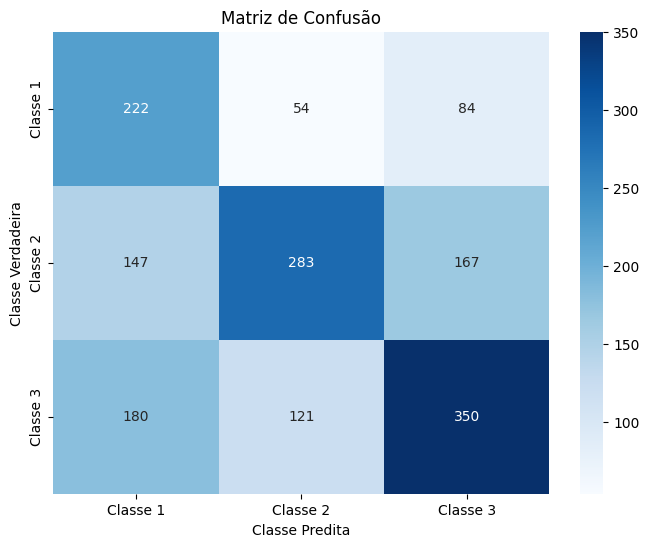

In [77]:
# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred_classes)

# Definir as classes
classes = ['Classe 1', 'Classe 2', 'Classe 3']

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

In [57]:
with open('model.pkl', 'wb') as arquivo:
    pickle.dump(model, arquivo)
with open('model.pkl', 'rb') as arquivo:
    modelo_model = pickle.load(arquivo)

# Modelo Random Forest - sem gridsearch


### Carregando os dados
Os dados são carregados e qualquer linha contendo valores ausentes é removida do DataFrame df_word2vec.

In [79]:
# Carregar os dados
df_word2vec = df_word2vec.dropna()

### Separando as features e o target
O target é atribuído à variável target, que contém a coluna 'sentimentoNumerico'. <br>As features são atribuídas à variável features, que contém todas as colunas a partir da coluna 2 até a coluna 102

In [80]:
# Separar as features e o target
target = df_word2vec['sentimentoNumerico']
features = df_word2vec.iloc[:, 2:102]

### Dividindo os dados em treinamento e teste
Os dados são divididos em conjuntos de treinamento e teste utilizando a função train_test_split do scikit-learn.

In [81]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Construindo o modelo Random Forest
O modelo Random Forest é construído utilizando a classe RandomForestClassifier do scikit-learn. É definido o número de estimadores como 100 e o parâmetro random_state como 42.

In [82]:
# Construir o modelo Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

### Treinar o modelo
O modelo Random Forest é treinado utilizando o conjunto de treinamento (X_train e y_train).

In [83]:
# Treinar o modelo
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Aplicação da validação cruzada
Validação Cruzada no modelo Random Forest para avaliar o desempenho do modelo em diferentes conjuntos de treinamento e teste.

In [84]:
# Aplicar a validação cruzada
cv_scores = cross_val_score(model_rf, X_train, y_train, cv=5)  # cv=5 indica 5 folds de validação cruzada

# Imprimir os scores de validação cruzada
print("Scores de validação cruzada:", cv_scores)
print("Média dos scores:", np.mean(cv_scores))

Scores de validação cruzada: [0.57575758 0.6029526  0.59486781 0.60730949 0.58631415]
Média dos scores: 0.593440325011087


### Avaliando o modelo
O modelo treinado é avaliado utilizando o conjunto de teste (X_test). As previsões são geradas usando o método predict e são armazenadas na variável y_pred.

In [85]:
# Avaliar o modelo
y_pred = model_rf.predict(X_test)

# Gerar o relatório de classificação
classification_report = classification_report(y_test, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.55      0.54      0.55       360
           1       0.66      0.57      0.61       597
           2       0.62      0.70      0.65       651

    accuracy                           0.61      1608
   macro avg       0.61      0.60      0.60      1608
weighted avg       0.62      0.61      0.61      1608



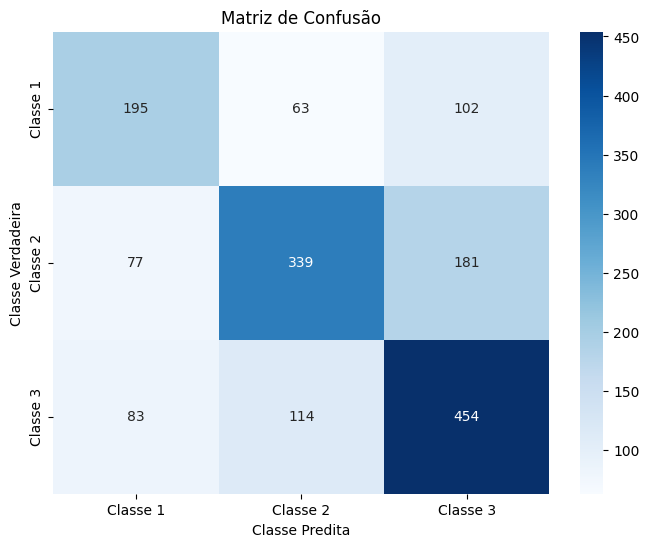

In [86]:
# Gerar a matriz de confusão
matriz_confusao = confusion_matrix(y_test, y_pred)

# Definir as classes
classes = ['Classe 1', 'Classe 2', 'Classe 3']

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

# Modelo Random Forest - com gridsearch

In [66]:
# Carregar os dados
df_word2vec = df_word2vec.dropna()

# Separar as features e o target
target = df_word2vec['sentimentoNumerico']
features = df_word2vec.iloc[:, 2:102]

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Definir o modelo Random Forest
model_rf = RandomForestClassifier(random_state=42)

# Definir os hiperparâmetros a serem testados
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árvores na floresta
}

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5)

# Executar o GridSearchCV
grid_search.fit(X_train, y_train)

# Obter os melhores hiperparâmetros encontrados
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

# Treinar o modelo final com os melhores hiperparâmetros
model_rf_best = RandomForestClassifier(n_estimators=best_params['n_estimators'], random_state=42)
model_rf_best.fit(X_train, y_train)

# Avaliar o modelo no conjunto de teste
y_pred = model_rf_best.predict(X_test)

# Gerar o relatório de classificação
classification_report = classification_report(y_test, y_pred)
print(classification_report)

# Gerar a matriz de confusão
matriz_confusao2 = confusion_matrix(y_test, y_pred)

# Definir as classes
classes = ['Classe 1', 'Classe 2', 'Classe 3']

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao2, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

Melhores hiperparâmetros: {'n_estimators': 300}


TypeError: ignored

### Exportação com a biblioteca pickle

In [ ]:
with open('model_rf.pkl', 'wb') as arquivo:
    pickle.dump(model, arquivo)
with open('model_rf.pkl', 'rb') as arquivo:
    modelo_model_rf = pickle.load(arquivo)

# Modelo Decision Tree - sem gridsearch

In [ ]:
# Carregar os dados
df_word2vec = df_word2vec.dropna()

# Separar as features e o target
target = df_word2vec['sentimentoNumerico']
features = df_word2vec.iloc[:, 2:102]

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Construir o modelo de árvore de decisão
model = DecisionTreeClassifier()

# Aplicar a validação cruzada
cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # cv=5 para 5 folds de validação cruzada

# Imprimir os scores de validação cruzada
print("Scores de validação cruzada:", cv_scores)
print("Média dos scores:", np.mean(cv_scores))

# Treinar o modelo final
model.fit(X_train, y_train)

# Avaliar o modelo no conjunto de teste
y_pred = model.predict(X_test)

# Gerar o relatório de classificação
classification_report = classification_report(y_test, y_pred)
print(classification_report)

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Definir as classes
classes = np.unique(target)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

# Modelo Decision Tree - com gridsearch

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# Carregar os dados
df_word2vec = df_word2vec.dropna()

# Separar as features e o target
target = df_word2vec['sentimentoNumerico']
features = df_word2vec.iloc[:, 2:102]

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Definir o modelo de árvore de decisão
model_decision_tree = DecisionTreeClassifier()

# Definir os hiperparâmetros a serem testados
param_grid = {
    'criterion': ['gini', 'entropy'],  # Critério para medir a qualidade da divisão
    'max_depth': [None, 5, 10],  # Profundidade máxima da árvore
}

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model_decision_tree, param_grid=param_grid, cv=5)

# Executar o GridSearchCV
grid_search.fit(X_train, y_train)

# Obter os melhores hiperparâmetros encontrados
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

# Treinar o modelo final com os melhores hiperparâmetros
model_best = DecisionTreeClassifier(criterion=best_params['criterion'], max_depth=best_params['max_depth'])
model_best.fit(X_train, y_train)

# Avaliar o modelo no conjunto de teste
y_pred = model_best.predict(X_test)

# Gerar o relatório de classificação
classification_report = classification_report(y_test, y_pred)
print(classification_report)

### Exportação com a biblioteca pickle

In [ ]:
with open('model_decision_tree.pkl', 'wb') as arquivo:
    pickle.dump(model, arquivo)
with open('model_decision_tree.pkl', 'rb') as arquivo:
    modelo_model_decision_tree = pickle.load(arquivo)